In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from timm import create_model

In [3]:
from fastai.vision.all import *

In [4]:
set_seed(999, reproducible=True)
BATCH_SIZE = 8

In [5]:
dataset_path = Path('../datasets/kaggle/petfinder/')
dataset_path.ls()

(#13) [Path('../datasets/kaggle/petfinder/train_5folds.csv'),Path('../datasets/kaggle/petfinder/train_10folds.csv'),Path('../datasets/kaggle/petfinder/test.csv'),Path('../datasets/kaggle/petfinder/train.csv'),Path('../datasets/kaggle/petfinder/test'),Path('../datasets/kaggle/petfinder/sample_submission.csv'),Path('../datasets/kaggle/petfinder/archive.zip'),Path('../datasets/kaggle/petfinder/.ipynb_checkpoints'),Path('../datasets/kaggle/petfinder/train'),Path('../datasets/kaggle/petfinder/crop')...]

In [6]:
df = pd.read_csv(dataset_path/'mytrain.csv')
df.head()

,Unnamed: 0,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,is_cat
0,0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0
1,1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,1
2,2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,0
3,3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,0
4,4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,0


In [7]:
df['path'] = df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head()

,Unnamed: 0,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,is_cat,path
0,9122,ebaaa8e384b3d2f0a56c7ff7675c154c,0,0,1,1,0,0,0,0,0,0,0,1,50,0,../datasets/kaggle/petfinder/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,1469,25e3bf4267c2dc3f579b779418221bb7,0,1,1,1,0,1,0,1,0,0,1,0,25,0,../datasets/kaggle/petfinder/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,3970,6548166fb3fda22b67881176397f0223,0,0,1,1,0,1,0,0,0,0,0,0,27,0,../datasets/kaggle/petfinder/train/6548166fb3fda22b67881176397f0223.jpg
3,2760,472c40116e1833555715e4774445ae5b,0,1,1,1,0,0,0,0,1,1,0,0,19,0,../datasets/kaggle/petfinder/train/472c40116e1833555715e4774445ae5b.jpg
4,4798,7b77e1a6d93667b575d57db83facd860,0,1,1,1,0,0,0,1,0,0,0,0,27,0,../datasets/kaggle/petfinder/train/7b77e1a6d93667b575d57db83facd860.jpg


In [8]:
len_df = len(df)
print(f"There are {len_df} images")

There are 9912 images


The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.59199010577444


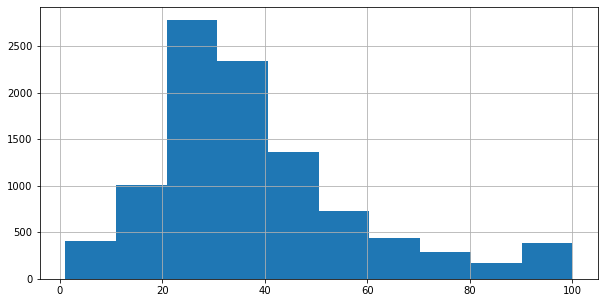

In [9]:
df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {df['Pawpularity'].std()}")

In [10]:
df['norm_score'] = df['Pawpularity']/100
df['norm_score']

0       0.50
1       0.25
2       0.27
3       0.19
4       0.27
        ... 
9907    0.26
9908    0.65
9909    0.38
9910    0.44
9911    0.62
Name: norm_score, Length: 9912, dtype: float64

In [11]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [12]:
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(df)))))
# num_bins

<AxesSubplot:>

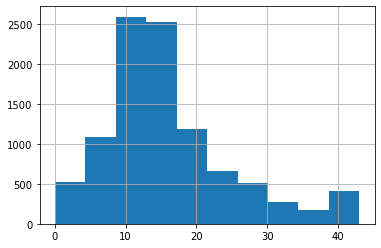

In [13]:
df['bins'] = pd.cut(df['norm_score'], bins=num_bins, labels=False)
df['bins'].hist()

In [14]:
# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('beit_large_patch16_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(self.model.embed_dim, 1)
#         self.cls_head = nn.Linear(self.model.embed_dim, 1)
        
#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)
        
        
#         return torch.cat([reg, is_cat], 1)


# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('vit_large_patch16_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(self.model.embed_dim, 1)
#         self.cls_head = nn.Linear(self.model.embed_dim, 1)
        
#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)
        
        
#         return torch.cat([reg, is_cat], 1)
    
    
# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('twins_svt_large', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(self.model.embed_dims[-1], 1)
#         self.cls_head = nn.Linear(self.model.embed_dims[-1], 1)
        

#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)
        
#         return torch.cat([reg, is_cat], 1)


    

# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('swin_large_patch4_window7_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(1536, 1)
#         self.cls_head = nn.Linear(1536, 1)


#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)

        
#         return torch.cat([reg, is_cat], 1)


# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('twins_svt_large', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(self.model.embed_dims[-1], 1)
#         self.cls_head = nn.Linear(self.model.embed_dims[-1], 1)
#         self.face_head = nn.Linear(self.model.embed_dims[-1], 1)
#         self.blur_head = nn.Linear(self.model.embed_dims[-1], 1)
        

#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)
#         face = self.face_head(features)
#         blur = self.blur_head(features)
        
#         return torch.cat([reg, is_cat, face, blur], 1)



# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('swin_large_patch4_window7_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(1536, 1)
#         self.cls_head = nn.Linear(1536, 1)
#         self.face_head = nn.Linear(1536, 1)
#         self.blur_head = nn.Linear(1536, 1)
    
#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)
#         face = self.face_head(features)
#         blur = self.blur_head(features)

        
#         return torch.cat([reg, is_cat, face, blur], 1)


# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('beit_large_patch16_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(self.model.embed_dim, 1)
#         self.cls_head = nn.Linear(self.model.embed_dim, 1)
#         self.face_head = nn.Linear(self.model.embed_dim, 1)
#         self.blur_head = nn.Linear(self.model.embed_dim, 1)
        

#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)
#         face = self.face_head(features)
#         blur = self.blur_head(features)
        
#         return torch.cat([reg, is_cat, face, blur], 1)

# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('vit_large_patch16_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(self.model.embed_dim, 1)
#         self.cls_head = nn.Linear(self.model.embed_dim, 1)
#         self.face_head = nn.Linear(self.model.embed_dim, 1)
#         self.blur_head = nn.Linear(self.model.embed_dim, 1)
        

#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)
#         face = self.face_head(features)
#         blur = self.blur_head(features)
        
#         return torch.cat([reg, is_cat, face, blur], 1)


# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('swin_large_patch4_window7_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(1536, 1)
        
#         for label in meta_labels[1:]:
#             setattr(self, label+'_head', nn.Linear(1536, 1))
    
#     def forward(self, x):
#         features = self.model(x)
#         res = []
#         reg = self.reg_head(features)
#         res.append(reg)
#         for label in meta_labels[1:]:
#             head = getattr(self, label+'_head')
#             res.append(head(features))
        
#         return torch.cat(res, 1)
    
    
# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('beit_large_patch16_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(self.model.embed_dim, 1)
        
#         for label in meta_labels[1:]:
#             setattr(self, label+'_head', nn.Linear(self.model.embed_dim, 1))
    
#     def forward(self, x):
#         features = self.model(x)
#         res = []
#         reg = self.reg_head(features)
#         res.append(reg)
#         for label in meta_labels[1:]:
#             head = getattr(self, label+'_head')
#             res.append(head(features))
        
#         return torch.cat(res, 1)
    
class PetModel(nn.Module):
    def __init__(
        self,
        num_classes
    ):
        super().__init__()
        self.model = create_model('vit_large_patch16_224', num_classes=0, pretrained=True)
        self.reg_head = nn.Linear(self.model.embed_dim, 1)
        
        for label in meta_labels[1:]:
            setattr(self, label+'_head', nn.Linear(self.model.embed_dim, 1))
    
    def forward(self, x):
        features = self.model(x)
        res = []
        reg = self.reg_head(features)
        res.append(reg)
        for label in meta_labels[1:]:
            head = getattr(self, label+'_head')
            res.append(head(features))
        
        return torch.cat(res, 1)



In [15]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self):
        store_attr()
        self.bceloss = BCEWithLogitsLossFlat()
        
        for label in meta_labels[1:]:
            setattr(self, 'bceloss_' + label, BCEWithLogitsLossFlat())
        
    def __call__(self, pred, targ, *preds):
        # print(f"targ: {targ}, is_cat: {is_cat}")
        loss = self.bceloss(pred[:, 0], targ) 
        for i, label in enumerate(meta_labels[1:], 1):
            critic = getattr(self, 'bceloss_' + label)
            loss += 0.1 * critic(pred[:, i], preds[i-1])
            
        return loss
            
    
    def decodes(self, x):    return x[:, 0]>self.thresh
    def activation(self, x): return x


# class CombinedLoss:
#     "Dice and Focal combined"
#     def __init__(self):
#         store_attr()
#         self.bceloss1 = BCEWithLogitsLossFlat()
#         self.bceloss2 =  BCEWithLogitsLossFlat()
#         self.bceloss3 =  BCEWithLogitsLossFlat()
#         self.bceloss4 =  BCEWithLogitsLossFlat()
        
#     def __call__(self, pred, targ, is_cat, face, blur):
#         # print(f"targ: {targ}, is_cat: {is_cat}")
#         return self.bceloss1(pred[:, 0], targ) \
#                 + 0.2 * self.bceloss2(pred[:, 1], is_cat) \
#                 + 0.2 * self.bceloss3(pred[:, 2], face) \
#                 + 0.2 * self.bceloss4(pred[:, 3], blur)
    
#     def decodes(self, x):    return x[:, 0]>self.thresh
#     def activation(self, x): return x

# class CombinedLoss:
#     "Dice and Focal combined"
#     def __init__(self):
#         store_attr()
#         self.bceloss1 = BCEWithLogitsLossFlat()
#         self.bceloss2 =  BCEWithLogitsLossFlat()
        
#     def __call__(self, pred, targ, is_cat, face, blur):
#         # print(f"targ: {targ}, is_cat: {is_cat}")
#         return self.bceloss1(pred[:, 0], targ) \
#                 + 0.2 * self.bceloss2(pred[:, 1], is_cat)
    
#     def decodes(self, x):    return x[:, 0]>self.thresh
#     def activation(self, x): return x


mk_class('ActivationType', **{o:o.lower() for o in ['No', 'Sigmoid', 'Softmax', 'BinarySoftmax']},
         doc="All possible activation classes for `AccumMetric")

class AccumMetric(Metric):
    "Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."
    def __init__(self, func, dim_argmax=None, activation=ActivationType.No, thresh=None, to_np=False,
                 invert_arg=False, flatten=False, **kwargs):
        store_attr('func,dim_argmax,activation,thresh,flatten')
        self.to_np,self.invert_args,self.kwargs = to_np,invert_arg,kwargs

    def reset(self):
        "Clear all targs and preds"
        self.targs,self.preds = [],[]

    def accumulate(self, learn):
        "Store targs and preds from `learn`, using activation function and argmax as appropriate"
        pred = learn.pred
        if self.activation in [ActivationType.Softmax, ActivationType.BinarySoftmax]:
            pred = F.softmax(pred, dim=self.dim_argmax)
            if self.activation == ActivationType.BinarySoftmax: pred = pred[:, -1]
        elif self.activation == ActivationType.Sigmoid: pred = torch.sigmoid(pred)
        elif self.dim_argmax: pred = pred.argmax(dim=self.dim_argmax)
        if self.thresh:  pred = (pred >= self.thresh)
        self.accum_values(pred,learn.y,learn)

    def accum_values(self, preds, targs,learn=None):
        "Store targs and preds"
        to_d = learn.to_detach if learn is not None else to_detach
        preds,targs = to_d(preds),to_d(targs)
        if self.flatten: preds,targs = flatten_check(preds,targs)
        self.preds.append(preds)
        self.targs.append(targs[0])

    def __call__(self, preds, targs):
        "Calculate metric on one batch of data"
        self.reset()
        self.accum_values(preds,targs)
        return self.value

    @property
    def value(self):
        "Value of the metric using accumulated preds and targs"
        if len(self.preds) == 0: return
        preds,targs = torch.cat(self.preds),torch.cat(self.targs)
        if self.to_np: preds,targs = preds.numpy(),targs.numpy()
        return self.func(targs, preds, **self.kwargs) if self.invert_args else self.func(preds, targs, **self.kwargs)

    @property
    def name(self):  return self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__


def petfinder_rmse(input, target):
    # print("input:", input)
    # print("target:", target)
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input[:, 0].flatten()), target))

In [16]:
class MyImageDataLoaders(DataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for computer vision problems"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, suff='', label_cols=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from `df` using `fn_col` and `label_col`"
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        dblock = DataBlock(blocks=(ImageBlock, *y_block),
                           get_x=ColReader(fn_col, pref=pref, suff=suff),
                           get_y=[ColReader(label_col, label_delim=label_delim) for label_col in label_cols],
                           n_inp = 1,
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)

In [17]:
import gc
import torch
from sklearn.model_selection import KFold
from  sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from scipy.special import expit

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

df['fold'] = -1

super_final_predictions = []
super_final_predictions2 = []
super_final_oof_predictions = []
super_final_oof_predictions2 = []
super_final_oof_true = []

super_acc_predictions = []
super_face_predictions = []
super_blur_predictions = []
super_acc_true = []
super_face_true = []
super_blur_true = []

meta_labels = ["norm_score", "Eyes", "Face", "Near", "Action", "Accessory", "Group", "Collage", \
               "Human", "Occlusion", "Info", "Blur", "is_cat"]

N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for fold, (idx, val_idx) in enumerate(strat_kfold.split(df.index, df['bins'])):
    train_df = df.loc[idx].reset_index(drop=True)
    val_df = df.loc[val_idx].reset_index(drop=True)


#     paw_block = DataBlock(blocks = (ImageBlock, RegressionBlock, RegressionBlock),  # input/ output
#                           get_x = ColReader('path'), 
#                           get_y = [ColReader('norm_score'), ColReader('is_cat')], 
#                           n_inp = 1,
#                           item_tfms = Resize(224), 
#                           batch_tfms = setup_aug_tfms([#Flip(p=0.5),
#                                           Brightness(max_lighting=0.2, p=0.75), 
#                                           Contrast(max_lighting=0.2, p=0.75), 
#                                           Hue(max_hue=0.1, p=0.75), 
#                                           Saturation(max_lighting=0.2, p=0.75)])
#                           # RandomErasing(p=0.5, sl=0.0, sh=0.3, min_aspect=0.3, max_count=1)
#                          )

#     dls = paw_block.dataloaders(
#         train_df, 
#         batch_size=BATCH_SIZE, 
#         y_block=(RegressionBlock, RegressionBlock), 
#         num_workers=8
#     )

#     dls = MyImageDataLoaders.from_df(train_df, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
#                                # valid_col='is_valid', #
#                                seed=999, #seed
#                                fn_col='path', #filename/path is in the second column of the DataFrame
#                                label_cols=['norm_score', 'is_cat'], #label is in the first column of the DataFrame
#                                y_block=(RegressionBlock, RegressionBlock), #The type of target
#                                bs=BATCH_SIZE, #pass in batch size
#                                num_workers=8,
#                                item_tfms=Resize(224), #pass in item_tfms
#                                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    

    # dls = MyImageDataLoaders.from_df(train_df, #pass in train DataFrame
    #                            valid_pct=0.2, #80-20 train-validation random split
    #                        # valid_col='is_valid', #
    #                        seed=999, #seed
    #                        fn_col='path', #filename/path is in the second column of the DataFrame
    #                        label_cols=['norm_score', 'is_cat', 'Face', 'Blur'], #label is in the first column of the DataFrame
    #                        y_block=(RegressionBlock, RegressionBlock, RegressionBlock, RegressionBlock), #The type of target
    #                        bs=BATCH_SIZE, #pass in batch size
    #                        num_workers=8,
    #                        item_tfms=Resize(224), #pass in item_tfms
    #                        batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms

    dls = MyImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                       # valid_col='is_valid', #
                       seed=999, #seed
                       fn_col='path', #filename/path is in the second column of the DataFrame
                       label_cols=meta_labels, #label is in the first column of the DataFrame
                       y_block=tuple([RegressionBlock] * len(meta_labels)), #The type of target
                       bs=BATCH_SIZE, #pass in batch size
                       num_workers=8,
                       item_tfms=Resize(224), #pass in item_tfms
                       batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    
    model = PetModel(num_classes=0)

    learn = Learner(
        dls, 
        model, 
        loss_func=CombinedLoss(), 
        metrics=AccumMetric(func = petfinder_rmse),
        # model_dir = "tf_efficientnet_b0"
        # model_dir = "beit_large_patch16_224_allmeta_nodataleak_1e5lr_10fold"
        model_dir = "vit_large_patch16_224_allmeta_nodataleak_1e5lr_10fold"
        # model_dir = "hybrid_bs8_20fold"
        # model_dir = "swin_large_patch4_window7_224_allmeta_nodataleak_10fold"

    ).to_fp16()
    # learn.load(f'tf_efficientnet_b0_fold{fold}')
    # learn.load(f'swin_large_patch4_window7_224_fold{fold}')
    learn.load(f'vit_large_patch16_224_fold{fold}')


    val_dl = dls.test_dl(val_df)

    val_preds, _ = learn.tta(dl=val_dl, n=5, beta=0)
    # val_preds, _ = learn.get_preds(dl=val_dl)
    val_preds = val_preds.cpu().detach().numpy()
    # print("val_preds: ", val_preds[0])
    
    final_test_predictions = []
    final_test_predictions.extend(val_preds[:, 0].ravel().tolist())
    
    acc_test_predictions = []
    acc_tmp = expit(val_preds[:, 1])
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    acc_test_predictions.extend(acc_tmp.ravel().tolist())
    
    face_test_predictions = []
    face_tmp = expit(val_preds[:, 2])
    # print("acc_tmp：", acc_tmp) 
    face_tmp[face_tmp >= 0.5] = 1
    face_tmp[face_tmp < 0.5] = 0
    face_test_predictions.extend(face_tmp.ravel().tolist())
    
    blur_test_predictions = []
    blur_tmp = expit(val_preds[:, 3])
    # print("acc_tmp：", acc_tmp) 
    blur_tmp[blur_tmp >= 0.5] = 1
    blur_tmp[blur_tmp < 0.5] = 0
    blur_test_predictions.extend(blur_tmp.ravel().tolist())
    
    final_test_predictions = [sigmoid(x) * 100 for x in final_test_predictions]
    super_final_predictions.append(final_test_predictions)
    super_acc_predictions.append(acc_test_predictions)
    super_face_predictions.append(face_test_predictions)
    super_blur_predictions.append(blur_test_predictions)
    
    
    final_oof_true = val_df['Pawpularity'].values
    final_acc_true = val_df['is_cat'].values
    final_face_true = val_df['Face'].values
    final_blur_true = val_df['Blur'].values
    super_final_oof_true.append(final_oof_true)
    super_acc_true.append(final_acc_true)
    super_face_true.append(final_face_true)
    super_blur_true.append(final_blur_true)
    

    ##################
    # COMPUTE RSME
    rsme = np.sqrt(np.mean((super_final_oof_true[-1] - np.array(super_final_predictions[-1]))**2.0))
    print(f'Fold{fold+1} NN RSME =', rsme, '\n')
    acc = accuracy_score(super_acc_predictions[-1], super_acc_true[-1])
    print(f'Fold{fold+1} NN acc =', acc, '\n')
    face_acc = accuracy_score(super_face_predictions[-1], super_face_true[-1])
    print(f'Fold{fold+1} NN face acc =', face_acc, '\n')
    blur_acc = accuracy_score(super_blur_predictions[-1], super_blur_true[-1])
    print(f'Fold{fold+1} NN blur acc =', blur_acc, '\n')


    gc.collect()
    torch.cuda.empty_cache()
    

/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold1 NN RSME = 18.202957428850535 

Fold1 NN acc = 0.5604838709677419 

Fold1 NN face acc = 0.9445564516129032 

Fold1 NN blur acc = 0.18951612903225806 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold2 NN RSME = 17.63287767376367 

Fold2 NN acc = 0.5645161290322581 

Fold2 NN face acc = 0.9485887096774194 

Fold2 NN blur acc = 0.16129032258064516 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold3 NN RSME = 18.404072533107975 

Fold3 NN acc = 0.557013118062563 

Fold3 NN face acc = 0.934409687184662 

Fold3 NN blur acc = 0.14833501513622604 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold4 NN RSME = 17.460426481819365 

Fold4 NN acc = 0.5660948536831484 

Fold4 NN face acc = 0.9455095862764884 

Fold4 NN blur acc = 0.1584258324924319 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold5 NN RSME = 18.533132571018257 

Fold5 NN acc = 0.5671039354187689 

Fold5 NN face acc = 0.9273461150353178 

Fold5 NN blur acc = 0.13521695257315844 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold6 NN RSME = 17.10766673509993 

Fold6 NN acc = 0.5549949545913219 

Fold6 NN face acc = 0.9283551967709385 

Fold6 NN blur acc = 0.16851664984863773 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold7 NN RSME = 18.440027940462308 

Fold7 NN acc = 0.5782038345105953 

Fold7 NN face acc = 0.9384460141271443 

Fold7 NN blur acc = 0.17860746720484358 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold8 NN RSME = 18.521181104614712 

Fold8 NN acc = 0.5600403632694249 

Fold8 NN face acc = 0.9384460141271443 

Fold8 NN blur acc = 0.17860746720484358 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold9 NN RSME = 18.615967626126363 

Fold9 NN acc = 0.574167507568113 

Fold9 NN face acc = 0.9162462159434914 

Fold9 NN blur acc = 0.13420787083753785 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold10 NN RSME = 17.551172544829686 

Fold10 NN acc = 0.5418768920282543 

Fold10 NN face acc = 0.9273461150353178 

Fold10 NN blur acc = 0.17558022199798184 



In [18]:
true = np.hstack(super_final_oof_true)

oof = np.hstack(super_final_predictions)
rsme = np.sqrt( np.mean( (oof - true)**2.0 ))
print('Overall CV NN head RSME =',rsme)

Overall CV NN head RSME = 18.054496985012573


In [19]:
def my_mse(pred, gt):
    return np.sqrt(np.mean((pred-gt)**2))

In [20]:
high_thresholds = [48, 53, 58, 63, 68, 73, 78, 83, 88]
low_thresholds = [22,20,18,16,14,12,10,8,6]
weights = [0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95]

val_preds = oof.copy()
mse = my_mse(val_preds, true)
best_mse = float("inf")
print("original mse:{}".format(mse))
for weight in weights:
    for high in high_thresholds:
        for low in low_thresholds:
            val_preds = oof.copy()
            for i in range(len(val_preds)):
                if val_preds[i] > high:
                    val_preds[i] = val_preds[i] * weight + 38 * (1-weight)
                elif val_preds[i] < low:
                    val_preds[i] = val_preds[i] * weight + 38 * (1-weight)
            mse = my_mse(val_preds, true)
            if mse < best_mse:
                best_mse = mse
            print("low high mse:{},({},{}),weight:{}".format(mse, low, high, weight))
            
            val_preds = oof.copy()
            for i in range(len(val_preds)):
                if val_preds[i] > high:
                    val_preds[i] = val_preds[i] * weight
            mse = my_mse(val_preds, true)
            if mse < best_mse:
                best_mse = mse
            print("high mse:{},({}, ),weight:{}".format(mse, high, weight))
            
            val_preds = oof.copy()
            for i in range(len(val_preds)):
                if val_preds[i] < low:
                    val_preds[i] = val_preds[i] * weight 
            mse = my_mse(val_preds, true)
            if mse < best_mse:
                best_mse = mse
            print("low mse:{},(,{}),weight:{}".format(mse, low, weight))
print("best mse: ", best_mse)

original mse:18.054496985012573
low high mse:18.23547872848083,(22,48),weight:0.5
high mse:21.198003288792627,(48, ),weight:0.5
low mse:18.276482654360944,(,22),weight:0.5
low high mse:18.244676379163128,(20,48),weight:0.5
high mse:21.198003288792627,(48, ),weight:0.5
low mse:18.15210197943946,(,20),weight:0.5
low high mse:18.244873591274406,(18,48),weight:0.5
high mse:21.198003288792627,(48, ),weight:0.5
low mse:18.091519769242968,(,18),weight:0.5
low high mse:18.245317363608848,(16,48),weight:0.5
high mse:21.198003288792627,(48, ),weight:0.5
low mse:18.069595962287828,(,16),weight:0.5
low high mse:18.25145756280143,(14,48),weight:0.5
high mse:21.198003288792627,(48, ),weight:0.5
low mse:18.058329157356653,(,14),weight:0.5
low high mse:18.25310930870943,(12,48),weight:0.5
high mse:21.198003288792627,(48, ),weight:0.5
low mse:18.05572973073382,(,12),weight:0.5
low high mse:18.25472608480332,(10,48),weight:0.5
high mse:21.198003288792627,(48, ),weight:0.5
low mse:18.054496985012573,(,10

# 以下数据存在数据泄露 

## swin multitask only is_cat
original mse:16.192842729437746

low mse:16.192701968357436,(,16),weight:0.7

## beit multitask only is_cat
original mse:15.98459252148044

low mse:15.984586633801998,(,16),weight:0.95

## vit multitask only is_cat

original mse:16.2981727797447

low high mse:16.29797834074156,(22,88),weight:0.95


## beit 3 multitask

alpha: 0.1

original mse:16.22790502114363

low high mse:16.225487257613953,(22,83),weight:0.95

## beit 3 multitask sharehead

alpha: 0.1

original mse:16.649369726231615

low mse:16.64869348224422,(,22),weight:0.9

## swin 3 multitask

alpha: 0.2

lr: 2e-5

original mse:15.85139221067311

low high mse:15.850463755096367,(22,88),weight:0.95

## vit 3 multitask

alpha: 0.2

lr: 1e-6

original mse:16.804435774966635

low high mse:16.787767098550944,(22,88),weight:0.8

## xcit_large_24_p8_224_dist 3 multitask

alpha: 0.2

lr:2e-5

Overall CV NN head RSME = 14.816484675402394

best mse:  14.816484675402394


## twins_svt_large

alpha: 0.2

lr:2e-5

original mse:15.401333434030631

low mse:15.4010515046382,(,16),weight:0.65


## pit_b_224

alpha: 0.2

lr:2e-5

original mse:15.471050312088204

low mse:15.470296904171267,(,22),weight:0.95

# 无数据泄露


## swin_large_patch4_window7_224_multitask_nodataleak

alpha: 0.2

lr: 2e-5

original mse:17.555202074336272

low high mse:17.51319074359096,(22,63),weight:0.85

## beit_large_patch16_224

alpha: 0.2

lr: 2e-5

Overall CV NN head RSME = 17.722995497484877

low high mse:17.661703525915126,(22,63),weight:0.8


## vit_large_patch16_224

alpha: 0.2

lr: 2e-5

original mse:17.73153346128495

low high mse:17.664045963961904,(22,63),weight:0.8


## twins_svt_large

alpha: 0.2

lr: 2e-5

original mse:17.572092837429103

low high mse:17.55461721958626,(22,68),weight:0.9

## swin_large_patch4_window7_224 3multitask 


alpha: 0.2

lr: 2e-5

original mse:17.64504439787316

low high mse:17.582372940348083,(22,63),weight:0.8


## beit_large_patch16_224 3multitask

alpha: 0.2

lr: 2e-5

Overall CV NN head RSME = 17.92384974876976

low high mse:17.852620943532802,(22,63),weight:0.8

## vit_large_patch16_224 3multitask

alpha: 0.2

lr: 2e-5

original mse:17.802190833825325

low high mse:17.753501367230854,(22,63),weight:0.85


## vit_large_patch16_224 3multitask lr4e-6

alpha: 0.2

lr: 4e-6

original mse:17.950609768797285

low high mse:17.92576873523309,(22,83),weight:0.75


## twins_svt_large 3multitask

alpha: 0.2

lr: 2e-5

original mse:17.73006784610281

low high mse:17.686577060125085,(22,78),weight:0.75

# All meta features

## swin_large_patch4_window7_224

8epoch

alpha: 0.1

lr:2e-5

original mse:17.74488682704567

low high mse:17.69384744281531,(22,78),weight:0.75


## beit_large_patch16_224

8epoch

alpha: 0.1

lr:4e-6

original mse:18.11855880727846

low high mse:17.978177950845332,(22,48),weight:0.8


## vit_large_patch16_224

8epoch

alpha: 0.1

lr:2e-5

original mse:18.12577503909522

low high mse:18.004536863041977,(22,48),weight:0.8

# swin_large_patch4_window7_224


10epoch

alpha: 0.1

lr:2e-5


original mse:17.755175805246434

low high mse:17.713360424737708,(22,78),weight:0.75



## beit_large_patch16_224

10epoch

alpha: 0.1

lr:1e-5

original mse:18.013346613805858

low high mse:17.888583831341975,(22,58),weight:0.8

# vit_large_patch16_224

10epoch

alpha: 0.1

lr:2e-5


original mse:18.0961359647282

low high mse:17.999075926719897,(22,63),weight:0.75

# vit_large_patch16_224

10epoch

alpha: 0.1

lr:1e-5

original mse:18.054496985012573

low high mse:17.941546284329895,(22,48),weight:0.8


In [21]:
import gc
import torch

print("end")
gc.collect()
torch.cuda.empty_cache()

end
